# **Keyword-Based News Classification Model**

# **Import Libraries**

In [77]:
# Step 1: Import required libraries
import re
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS
from sklearn.model_selection import train_test_split

# **Load dataset**

In [78]:
# Step 2: Load dataset
df = pd.read_json(r"C:\Users\bbuser\Desktop\News_Category\News_Category_Dataset_v3.json", lines=True)

# **Filter categories**

In [79]:
# Step 3: Keep only the 4 categories we need
df = df[df['category'].isin(["POLITICS","TRAVEL","SPORTS","HOME & LIVING"])]

# **Balance dataset**

In [80]:
# Step 4: Balance dataset
# Take exactly 1000 random samples from each category
df = df.groupby('category').apply(lambda x: x.sample(1000)).reset_index(drop=True)

C:\Users\bbuser\AppData\Local\Temp\ipykernel_20112\1829200156.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('category').apply(lambda x: x.sample(1000)).reset_index(drop=True)


# **Keep only needed columns**

In [81]:
# Step 5: Keep only the text (short_description) and label (category)
df = df[['category', 'short_description']]

# **Split train/test**

In [82]:
# Step 6: Split into train and test (80/20)
train, test = train_test_split(df, test_size=0.2, stratify=df['category'], random_state=42)

print("Train:", train.shape, "Test:", test.shape)
print(train["category"].value_counts(normalize=True))

Train: (3200, 2) Test: (800, 2)
category
TRAVEL           0.25
SPORTS           0.25
HOME & LIVING    0.25
POLITICS         0.25
Name: proportion, dtype: float64


# **Word Clouds & Frequent Words**

In [99]:
import re
from wordcloud import STOPWORDS

# Build a small stopword set (WordCloud's + a few extras)
stopwords = set(STOPWORDS) | {"’s", "s", "u", "–", "—", "’", "“", "”"}

def tokenize(text):
    # keep only letters/apostrophes; lowercase; turn into words
    words = re.findall(r"[a-z']+", str(text).lower())
    # drop stopwords and 1-letter tokens
    return [w for w in words if w not in stopwords and len(w) > 1]

# Example usage
sample_text = "The government is planning new sports events in the city."
print(tokenize(sample_text))

['government', 'planning', 'new', 'sports', 'events', 'city']


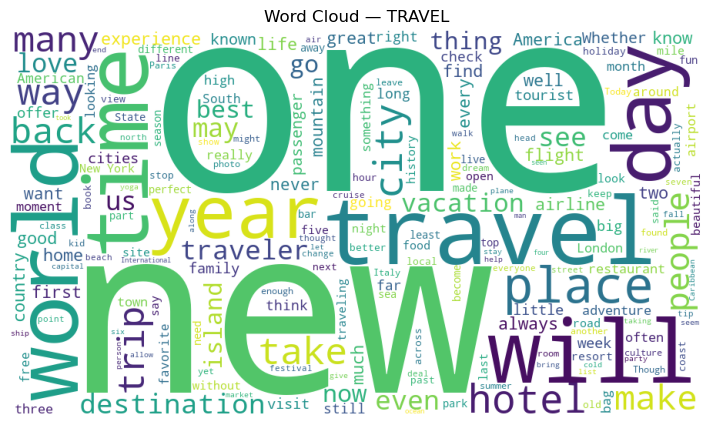

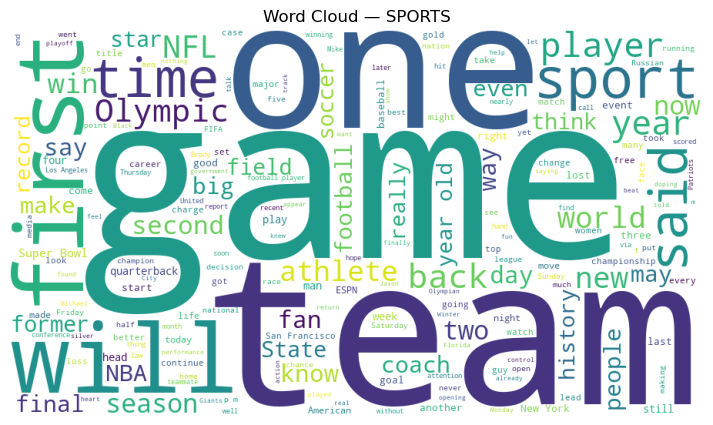

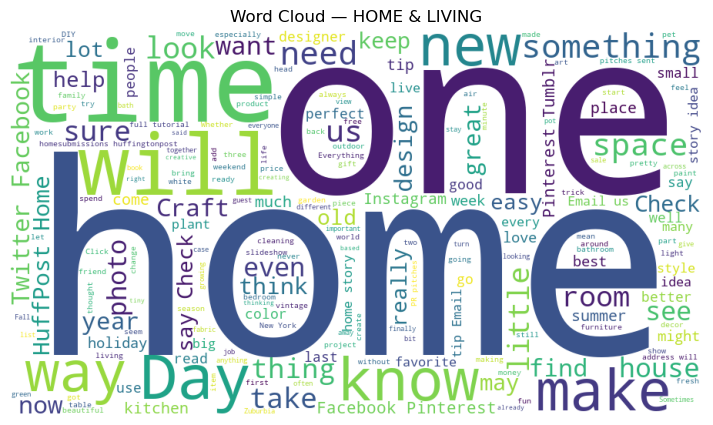

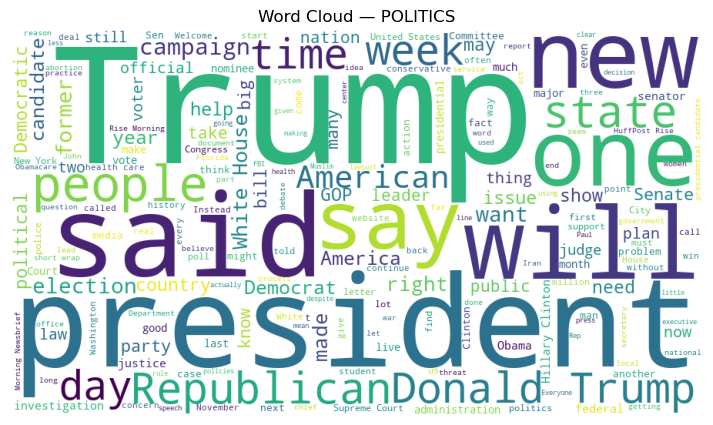

In [91]:
cats = train["category"].unique()

for cat in cats:
    text_all = " ".join(train.loc[train["category"] == cat, "short_description"].astype(str))
    wc = WordCloud(width=900, height=500, background_color="white", stopwords=stopwords).generate(text_all)

    plt.figure(figsize=(9,5))
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"Word Cloud — {cat}")
    plt.show()

In [93]:
from collections import Counter

# Build a frequency table per category from TRAINING TEXTS ONLY
freq_by_cat = {}
for cat in cats:
    tokens = []
    for txt in train.loc[train["category"] == cat, "short_description"]:
        tokens.extend(tokenize(txt))
    freq_by_cat[cat] = Counter(tokens)

# Example: see top 15 words for SPORTS
freq_by_cat["SPORTS"].most_common(15)

[('game', 44),
 ('one', 42),
 ('will', 36),
 ('first', 35),
 ('team', 34),
 ('said', 31),
 ('year', 30),
 ('time', 29),
 ('new', 28),
 ('back', 27),
 ('players', 24),
 ('sports', 24),
 ('nfl', 23),
 ('world', 20),
 ('season', 20)]

In [94]:
def top_k_sets(freq_by_cat, k):
    # returns: {category: set_of_top_k_words}
    return {cat: set([w for w, c in freq_by_cat[cat].most_common(k)]) for cat in freq_by_cat}

# quick sanity check
for k in [10, 20, 30, 50]:
    sets_k = top_k_sets(freq_by_cat, k)
    print(k, {cat: len(sets_k[cat]) for cat in cats})

10 {'TRAVEL': 10, 'SPORTS': 10, 'HOME & LIVING': 10, 'POLITICS': 10}
20 {'TRAVEL': 20, 'SPORTS': 20, 'HOME & LIVING': 20, 'POLITICS': 20}
30 {'TRAVEL': 30, 'SPORTS': 30, 'HOME & LIVING': 30, 'POLITICS': 30}
50 {'TRAVEL': 50, 'SPORTS': 50, 'HOME & LIVING': 50, 'POLITICS': 50}


In [71]:
# Step 8: Build frequent word sets (here top 30 words per category)
word_sets = {}
for cat in train['category'].unique():
    texts = train[train['category'] == cat]['short_description']
    word_sets[cat] = get_top_words(texts, 30)
print (cat)

POLITICS


# **Keyword-Based Classification**

In [57]:
# Step 9: Classification function
# Counts overlap of words in a text with each category’s word set
def classify(text, word_sets):
    words = set(text.lower().split())
    # Count how many words match in each category
    scores = {cat: len(words & set(ws)) for cat, ws in word_sets.items()}
    max_score = max(scores.values())
    # Handle ties: if more than one category has the same max overlap
    if list(scores.values()).count(max_score) > 1:
        return "unknown"
    return max(scores, key=scores.get)

In [95]:
# Tie rule: if multiple categories tie for highest overlap -> "unknown"
def predict_one(text, sets_k):
    words = set(tokenize(text))
    scores = {cat: len(words & sets_k[cat]) for cat in sets_k}
    max_score = max(scores.values())
    # handle ties
    if list(scores.values()).count(max_score) > 1:
        return "unknown"
    # category with highest overlap
    return max(scores, key=scores.get)

# Try one example
print(predict_one("Government announces a new travel policy for summer holidays", top_k_sets(freq_by_cat, 20)))

TRAVEL


# **Evaluation**

In [97]:
ks = [10, 20, 30, 50]
results = []

for k in ks:
    sets_k = top_k_sets(freq_by_cat, k)
    preds = test["short_description"].apply(lambda x: predict_one(x, sets_k))
    acc = (preds == test["category"]).mean()
    results.append({"k": k, "accuracy": acc})
    print(f"k={k}: accuracy={acc:.4f}")

k=10: accuracy=0.1600
k=20: accuracy=0.2400
k=30: accuracy=0.2737
k=50: accuracy=0.3063


# **Results & Reporting**

,k,accuracy
0,10,0.16000
1,20,0.24000
2,30,0.27375
3,50,0.30625


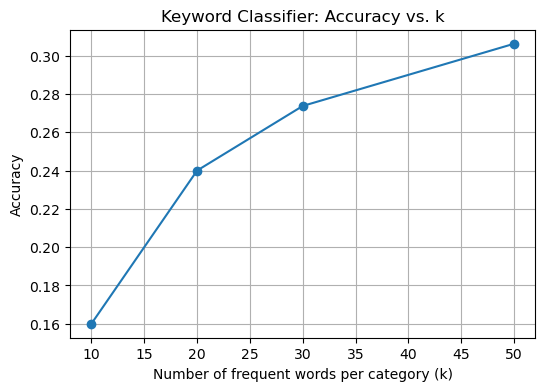

In [98]:
import matplotlib.pyplot as plt
import pandas as pd

res_df = pd.DataFrame(results)
display(res_df)

plt.figure(figsize=(6,4))
plt.plot(res_df["k"], res_df["accuracy"], marker="o")
plt.xlabel("Number of frequent words per category (k)")
plt.ylabel("Accuracy")
plt.title("Keyword Classifier: Accuracy vs. k")
plt.grid(True)
plt.show()